### Import libraries for experiments

In [1]:
import torch
from training_main import training_main, test
from utils import data_loading, normalization, filter_extraction, plot_results, plot_kernels
from CNN import CNN
from ScatNet import ScatNet2D
from kymatio.torch import Scattering2D
from scipy.fft import fft2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

c:\ProgramData\Anaconda3\envs\technica\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\ProgramData\Anaconda3\envs\technica\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\ProgramData\Anaconda3\envs\technica\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Data Loading and Normalization

In [2]:
# LOAD DATA
train_data, train_labels, test_data, test_labels = data_loading("./data/train/", "./data/test/")
data = train_data + test_data

# NORMALIZATION
data_transform = normalization(data)

Red ch mean =  0.2082946035683011 
Green ch mean =  0.2082298517705837 
Blue ch mean =  0.2082241406070435
Red ch std =  0.2120124417706629 
Green ch std =  0.211990008277464 
Blue ch std =  0.2119912744425196


Example images

Image shape: (512, 512, 3)


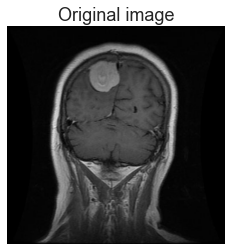

In [3]:
random.seed(42) 
image = random.sample(train_data, 1)
image = np.array(image)
image = np.squeeze(image, 0)
print(f"Image shape: {image.shape}")

plt.imshow(image)
plt.axis('off')
plt.title('Original image')
plt.show()

## CNN

In [4]:
MODEL_NAME = 'CNN'
NUM_FOLD = 10
num_epochs = 20

In [5]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))
model_CNN = CNN(input_channel=3, num_classes=2)
model_CNN.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_CNN.parameters():
    parameter.requires_grad = False


In [6]:
model_CNN

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [7]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

Accuracy 0.9816666666666667


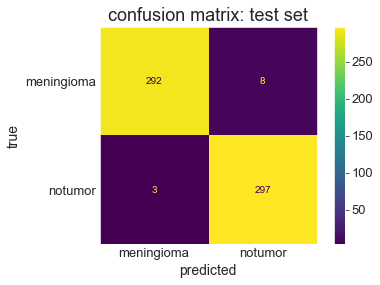

In [8]:
# TESTING
acc_CNN = test(data_transform, test_data, test_labels, model_CNN, MODEL_NAME, device='cpu')
print("Accuracy", acc_CNN)


### Extract Filters from CNN

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)


In [10]:
# Filter extraction
image = data_transform(image)
image = image.to(device)


single_channel = True if image.shape[0] == 1 else False

filter_extraction(model_CNN, MODEL_NAME, image, single_channel)

Total convolution layers: 4


## ScatNet 

In [11]:
MODEL_NAME = 'ScatNet'
NUM_FOLD = 10
num_epochs = 20

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))

# Define best model
L = 8
J = 2
scattering = Scattering2D(J=J, shape=(128, 128), L=L)
K = 81  # Input channels for the ScatNet
scattering = scattering.to(device)
model_ScatNet = ScatNet2D(input_channels=K, scattering=scattering, num_classes=2).to(device)
model_ScatNet.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_ScatNet.parameters():
    parameter.requires_grad = False

In [14]:
model_ScatNet

ScatNet2D(
  (scattering): Scattering2D()
  (lin): Linear(in_features=248832, out_features=576, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [15]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

Accuracy 0.9666666666666667


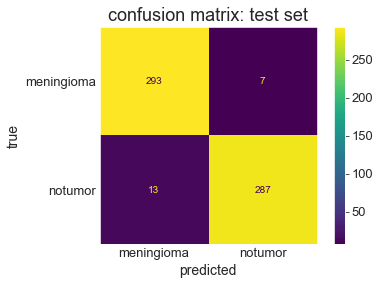

In [16]:
# TESTING
acc_ScatNet = test(data_transform, test_data, test_labels, model_ScatNet, MODEL_NAME, device='cpu')
print("Accuracy", acc_ScatNet)

### Extract Filters from ScatNet

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ScatNet = model_ScatNet.to(device)

In [18]:
# Filter extraction
scatter = model_ScatNet.scattering
plot_kernels(J, L, scatter, MODEL_NAME)

## INTEGRATED GRADIENTS

## Comparing XAI methods

In [19]:
# Imports

import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from CNN import CNN
from ScatNet import ScatNet2D
from torchvision.transforms import ToTensor, Compose, Resize, Normalize, ToPILImage
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import IntegratedGradients
from kymatio.torch import Scattering2D

import cv2

import numpy as np


In [28]:
# Attributions plot

def plot_train_label(image, mask):
    fig, axis = plt.subplots(1, 3, figsize=(12, 10))

    # axarr[0].imshow(np.squeezesqueeze(image), cmap='gray')
    axis[0].imshow(image)  #, cmap='gray')
    axis[0].set_ylabel('Axial View', fontsize=14)
    axis[0].set_xticks([])
    axis[0].set_yticks([])
    axis[0].set_title('CT', fontsize=14)

    # from matplotlib.colors import LinearSegmentedColormap
    # cmap = LinearSegmentedColormap.from_list("3colors", ['k', 'r', 'g'], N=3)

    axis[1].imshow(mask, cmap='viridis')  #, cmap='tab20c')
    axis[1].axis('off')
    axis[1].set_title('Mask', fontsize=14)

    im3 = axis[2].imshow(image, cmap='viridis', alpha=0.6)
    im3 = axis[2].imshow(mask, cmap='viridis', alpha=0.8)
    axis[2].axis('off')
    axis[2].set_title('Overlay', fontsize=14)

    divider = make_axes_locatable(axis[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


In [31]:
# IG SCRATCH
def ig_scratch(transformed_img, model, baseline, n_alpha):

    img = (torch.tensor(transformed_img)).to('cuda')

    difference_img_baseline = (img - baseline).reshape(3,128,128).to('cuda')

    alphas = torch.linspace(0.1,1,n_alpha) # compute for 10 values of alpha
    gradients_list = torch.empty(0,3,128,128).to('cuda')



    model.eval()
    for alpha in alphas:
        input = (baseline.reshape(3,128,128) + (alpha * difference_img_baseline)).reshape(1,3,128,128).to('cuda').requires_grad_(True)
        output = model(input)
        gradients = torch.autograd.grad(torch.max(output), input)[0] * 0.1
        gradients_list = torch.cat([gradients_list, gradients],dim=0)


    gradients_list = torch.sum(gradients_list, dim=0).reshape(1,3,128,128)

    gradients_list = difference_img_baseline * gradients_list

    gradients_list = (gradients_list - gradients_list.min()) / (gradients_list.max() - gradients_list.min())

    # transformed image
    plot_train_label(img.permute(1,2,0).cpu().numpy(), gradients_list[0].permute(1,2,0).cpu().numpy())
   


In [22]:
# IG CAPTUM

def ig_captum(transformed_img, model, baseline, n_alpha):
    img = transformed_img.to('cuda')

    ig = IntegratedGradients(model)
    attributions, delta = ig.attribute(img, baseline, target=0, return_convergence_delta=True, n_steps=n_alpha)
    
    attributions = attributions.squeeze(0)

    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    # plot transformed
    plot_train_label(transformed_img.squeeze(0).permute(1, 2, 0).cpu().numpy(), np.mean(attributions.permute(1, 2, 0).cpu().numpy(), axis=2))


In [25]:
# CONSTANT INTEGRATED GRADIENTS

# NO TUMOR
# img_name = 'Te-no_0010.jpg'  # notumor
# img_path = f'./data/test/notumor/{img_name}'

# TUMOR
# img_name = 'Te-me_0068.jpg'  # meningioma
img_name = 'Te-me_0157.jpg'  # meningioma
img_path = f'./data/test/meningioma/{img_name}'

n_alpha = 200

# read the image
# image = Image.open(img_path)
image = cv2.imread(img_path)

transformed_img = data_transform(image).unsqueeze(0).to('cuda')
baseline = torch.randn(1,3, 128, 128).to('cuda')


CLASS: TUMOR


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


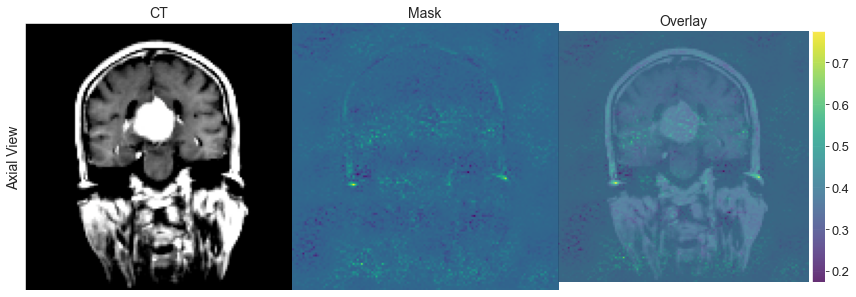

In [32]:
# MAIN CNN INTEGRATED GRADIENTS

model = model_CNN

print(f'CLASS: {"NO TUMOR" if torch.argmax(model(transformed_img)) == 1 else "TUMOR"}')
ig_captum(transformed_img, model, baseline, n_alpha)

CLASS: TUMOR


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


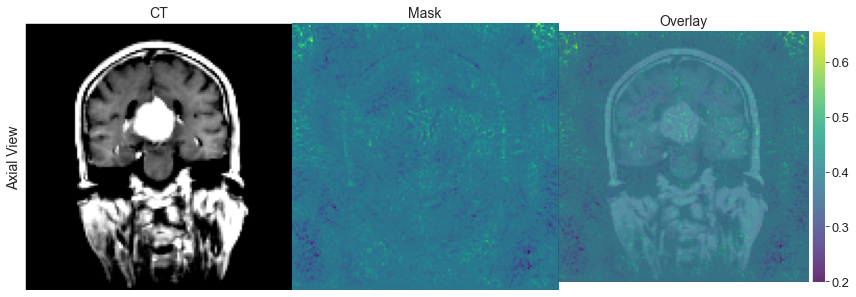

In [30]:
# MAIN SCATNET INTEGRATED GRADIENTS

model = model_ScatNet

print(f'CLASS: {"NO TUMOR" if torch.argmax(model(transformed_img)) == 1 else "TUMOR"}')
ig_captum(transformed_img, model, baseline, n_alpha)